##### Sentiment Analysis
This notebook leverages a NLP model pre-trained on portuguese/brazil reviews. The model is `ramonmedeiro1/bertimbau-products-reviews-pt-br` available on HuggingFace.

In [22]:
# Libraries setup
import os
import re
import string
import unicodedata
import nltk
import torch

import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

load_dotenv()

# Setup pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Download the WordNet resource
# nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rafal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# Define paths
fpath_data = os.environ.get("FPATH_DATA")

# Load reviews data
reviews = pd.read_csv(fpath_data+"order_reviews.csv")
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [24]:
# reviews[reviews['review_comment_title'].notnull()]

In [25]:
# reviews[reviews['review_comment_message'].notnull()]

In [26]:
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [27]:
# It looks like all reviews are from Brazil according to customers.csv

# Convert to datetime column review_creation_date
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])

# For the sake of simplicit, lets merge review comment title and message
reviews['review_concat'] = reviews['review_comment_title'].fillna('')+', '+reviews['review_comment_message'].fillna('')

# # Drop rows with null ['review_concat']
# reviews = reviews.dropna(subset=['review_concat'])

# Drop rows with only ', ' string
reviews = reviews[reviews.review_concat != ', ']

# Lets keep only relevant columns
reviews = reviews[['review_id', 'order_id', 'review_concat','review_creation_date']]

In [28]:
# reviews

##### Preprocessing

In [29]:
# Lets check if there are any numbers in the reviews - this will be helpfull for the second task
def search_numbers(text):
    return bool(re.search(r'\d+', text))

reviews['contain_num'] = reviews['review_concat'].apply(search_numbers)
# reviews[reviews['contain_num']==True].head(50)

In [30]:
def remove_emojis(text):
    """Remove emojis from the text."""
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [31]:
def keep_only_ascii(text):
    def is_supported(char):
        try:
            char.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            return False
        else:
            return True
        
    def clean_string(s):
        return ''.join(c for c in s if is_supported(c) or unicodedata.category(c) not in ['Cn', 'Co', 'Cs'])

    cleaned_list = [clean_string(s) for s in text]
    return [s for s in cleaned_list if s]  # Remove any empty strings

In [32]:
def remove_stopwords(tokens):
    """Eliminate common stopwords from the tokenized text.
    Stop words are commonly used words like "the," "is," or 
    "and" that don't carry much meaning and can be removed to reduce noise in the data
    """
    # stop_words = set(stopwords.words('english')) # English version - we will anyway use PT as the translation will be done after preprocessing
    stop_words = set(stopwords.words('portuguese')) # PT version
    return [word for word in tokens if word not in stop_words]

In [33]:
def tokenize_text(text):
    """Split the text into individual words or tokens."""
    return word_tokenize(text)

In [34]:
def remove_numbers(text):
    """Exclude numerical digits from the text."""
    return re.sub(r'\d+', '', text)

def remove_punctuation(text):
    """Remove punctuation marks from the text."""
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_extra_whitespaces(text):
    """Remove extra white space from text."""
    return re.sub(r'\s+', ' ', text, flags=re.I)

def remove_single_chars(text):
    """Remove all single characters from text"""
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

def remove_special_chars(text):
    """Remove all the special characters from text."""
    return re.sub(r'\W', ' ', text)

def remove_not_alphabetical(text):
    """Remove any character that isn't alphabetical."""
    return re.sub(r'[^a-zA-Z\s]', '', text)

In [35]:
# Final preprocessing pipeline, some of the functions might not be used in the solution, althrough defined
def preprocess(text):
    text = str(text).lower() # To lower
    text = remove_extra_whitespaces(text)
    # text = remove_numbers(text)
    text = remove_punctuation(text)
    text = tokenize_text(text)
    text = remove_stopwords(text)
    text = remove_emojis(text)
    text = keep_only_ascii(text)
    return text

In [36]:
reviews['reviews_processed'] = reviews['review_concat'].apply(preprocess)
reviews['reviews_processed_str'] = reviews['reviews_processed'].apply(' '.join)

In [37]:
# I decided to keep the numbers in the data
reviews[reviews['review_id']=='d21bbc789670eab777d27372ab9094cc']

,review_id,order_id,review_concat,review_creation_date,contain_num,reviews_processed,reviews_processed_str
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,"Ótimo, Loja nota 10",2018-07-10 00:00:00,True,"[ótimo, loja, nota, 10]",ótimo loja nota 10


##### Word cloud

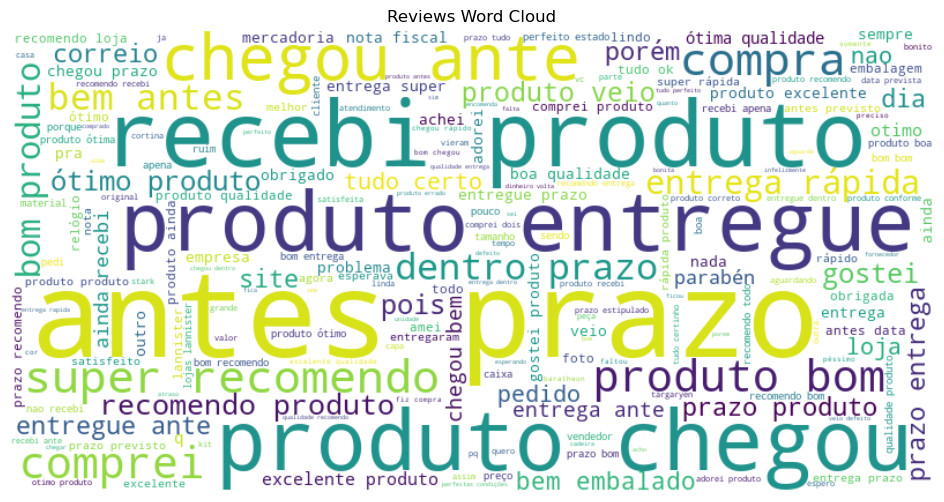

In [38]:
reviews_aio = ' '.join(reviews['reviews_processed_str'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_aio)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Reviews Word Cloud')
plt.show()

Text(0, 0.5, 'Frequency')

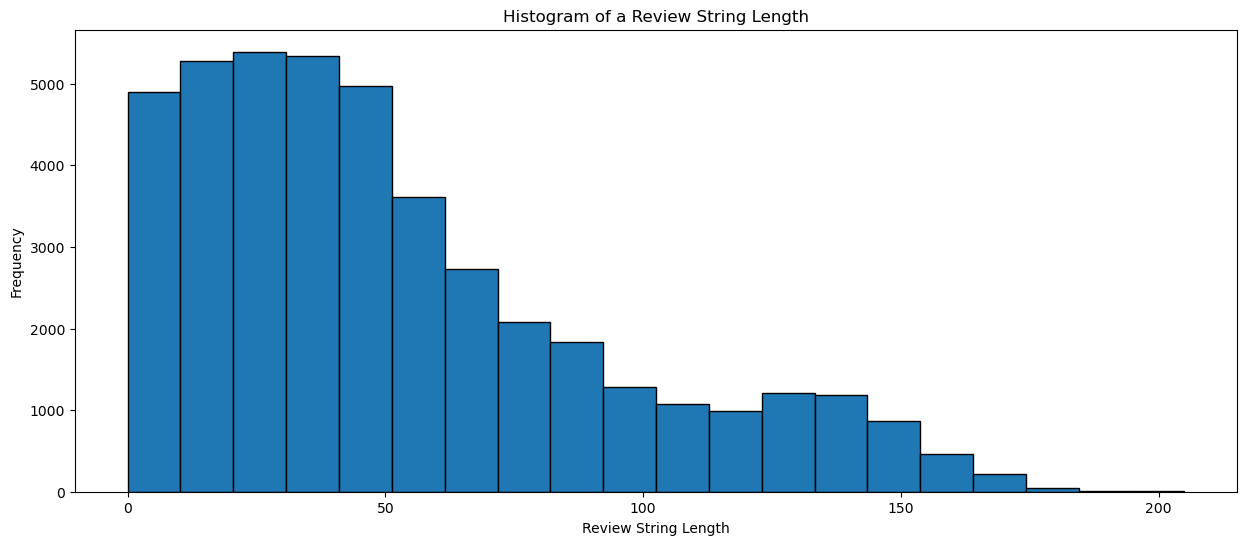

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
reviews['review_length'] = reviews['reviews_processed_str'].str.len()

# Histogram of review length
ax.hist(reviews['review_length'], bins=20, edgecolor='black')
ax.set_title('Histogram of a Review String Length')
ax.set_xlabel('Review String Length')
ax.set_ylabel('Frequency')

##### Sentiment analysis
As mentioned in the beginning, this notebook leverages `ramonmedeiro1/bertimbau-products-reviews-pt-br` pre-trained model from Huggingface

In [40]:
model_name = "ramonmedeiro1/bertimbau-products-reviews-pt-br"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = model.to(device)

e:\MiniConda\envs\vala\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [41]:
sentiment_classes = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    predicted_class = torch.argmax(probabilities, dim=1).item()
    predicted_sentiment = sentiment_classes[predicted_class]

    return predicted_sentiment

In [42]:
reviews['sentiment'] = reviews['reviews_processed_str'].apply(get_sentiment)
reviews

,review_id,order_id,review_concat,review_creation_date,contain_num,reviews_processed,reviews_processed_str,review_length,sentiment
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,", Recebi bem antes do prazo estipulado.",2017-04-21 00:00:00,False,"[recebi, bem, antes, prazo, estipulado]",recebi bem antes prazo estipulado,33,Very Positive
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,", Parabéns lojas lannister adorei comprar pela...",2018-03-01 00:00:00,False,"[parabéns, lojas, lannister, adorei, comprar, ...",parabéns lojas lannister adorei comprar intern...,91,Very Positive
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,"recomendo, aparelho eficiente. no site a marca...",2018-05-22 00:00:00,True,"[recomendo, aparelho, eficiente, site, marca, ...",recomendo aparelho eficiente site marca aparel...,124,Neutral
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,", Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,False,"[pouco, travandopelo, valor, ta, boa]",pouco travandopelo valor ta boa,31,Neutral
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,"Super recomendo, Vendedor confiável, produto o...",2018-05-23 00:00:00,False,"[super, recomendo, vendedor, confiável, produt...",super recomendo vendedor confiável produto ok ...,65,Positive
...,...,...,...,...,...,...,...,...,...
99983,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,", Entregou dentro do prazo. O produto chegou e...",2018-02-07 00:00:00,False,"[entregou, dentro, prazo, produto, chegou, con...",entregou dentro prazo produto chegou condições...,67,Positive
99990,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,", O produto não foi enviado com NF, não existe...",2018-05-19 00:00:00,False,"[produto, enviado, nf, existe, venda, nf, cert...",produto enviado nf existe venda nf certeza fic...,78,Very Negative
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,", Excelente mochila, entrega super rápida. Sup...",2018-03-22 00:00:00,False,"[excelente, mochila, entrega, super, rápida, s...",excelente mochila entrega super rápida super r...,59,Very Positive
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,", Solicitei a compra de uma capa de retrovisor...",2017-12-15 00:00:00,False,"[solicitei, compra, capa, retrovisor, celtapri...",solicitei compra capa retrovisor celtaprismame...,144,Negative


##### Results visualization

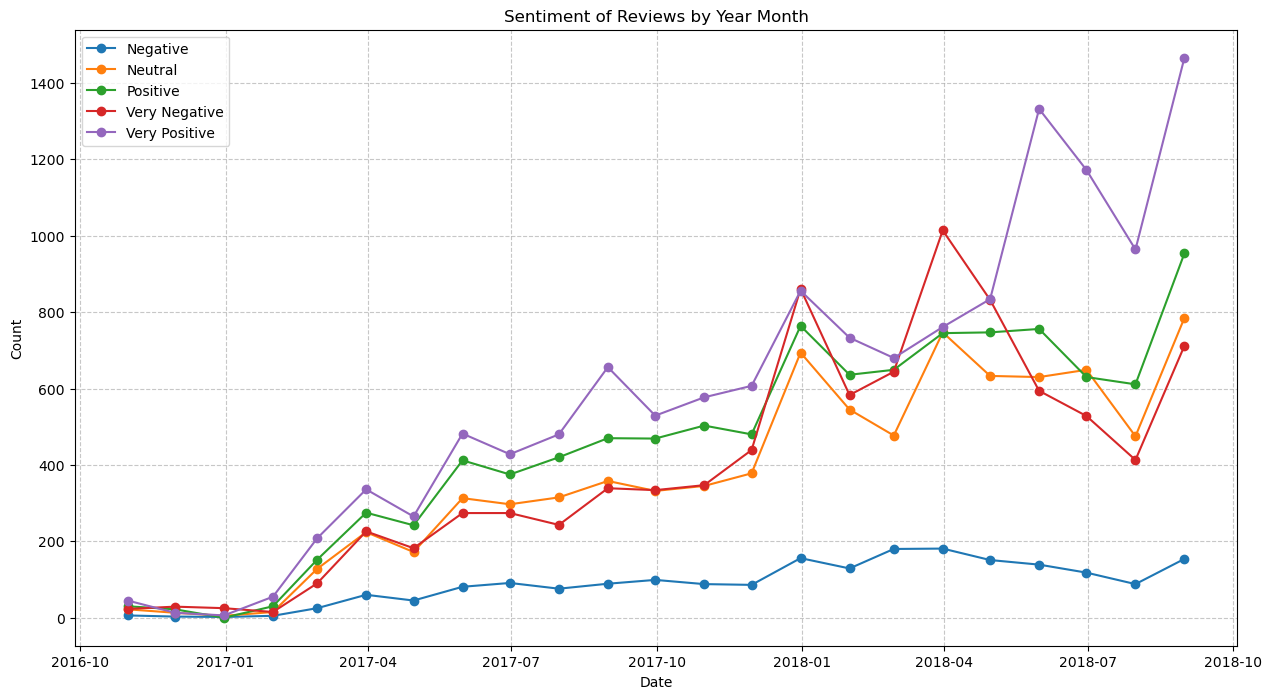

In [48]:
results = reviews.set_index('review_creation_date')
sentiment_over_time = results.resample('ME')['sentiment'].value_counts().unstack().fillna(0)

plt.figure(figsize=(15, 8))
for sentiment in sentiment_over_time.columns:
    plt.plot(sentiment_over_time.index, sentiment_over_time[sentiment], label=sentiment, marker='o')

plt.title('Sentiment of Reviews by Year Month')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

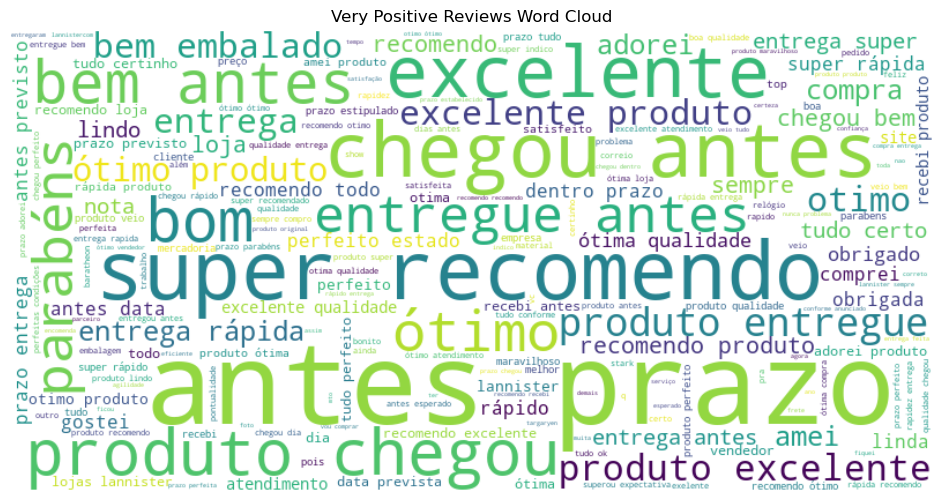

In [51]:
# WordCloud for a very positive sentiment
reviews_aio = ' '.join(reviews[reviews['sentiment']=='Very Positive']['reviews_processed_str'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_aio)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Very Positive Reviews Word Cloud')
plt.show()

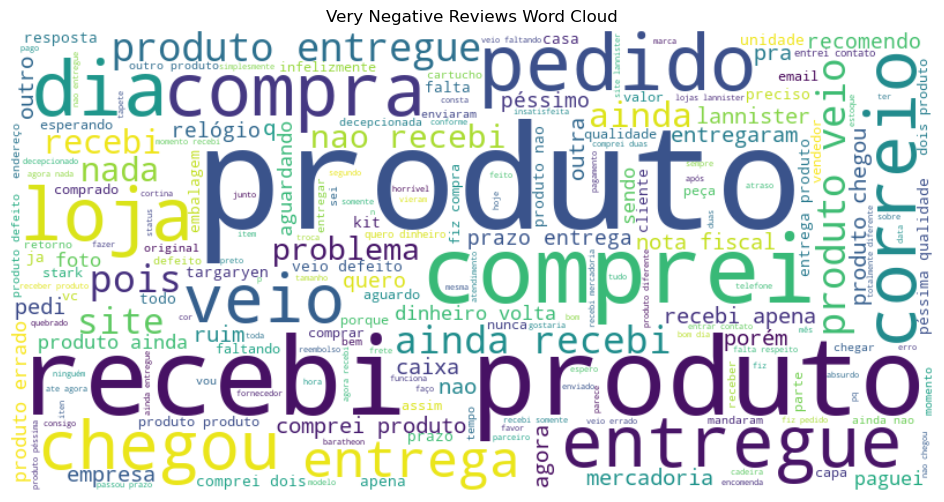

In [52]:
# WordCloud for a very negative sentiment
reviews_aio = ' '.join(reviews[reviews['sentiment']=='Very Negative']['reviews_processed_str'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_aio)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Very Negative Reviews Word Cloud')
plt.show()